In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stanford-rna-3d-folding/sample_submission.csv
/kaggle/input/stanford-rna-3d-folding/validation_sequences.csv
/kaggle/input/stanford-rna-3d-folding/test_sequences.csv
/kaggle/input/stanford-rna-3d-folding/validation_labels.csv
/kaggle/input/stanford-rna-3d-folding/train_labels.csv
/kaggle/input/stanford-rna-3d-folding/train_sequences.csv
/kaggle/input/stanford-rna-3d-folding/MSA/R1108.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/8EVR_EC.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/1ZDI_S.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/5FJ1_H.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/2NBY_A.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/3DEG_J.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/2M21_A.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/8U3M_A.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/2OM7_F.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/1ZC8_G.MSA.fasta
/kaggle/input/stanford-rna-3d-folding/MSA/6WW6_C.MSA.fast

In [2]:
# ---
# Cell: ALL-IN-ONE Environment Setup
# ---

import os
import shutil
import subprocess
import sys


def run_and_print(cmd):
    result = subprocess.run(cmd, capture_output=True, text=True)
    print(result.stdout)
    if result.stderr:
        print(result.stderr)


# ====== Gather Detailed System Information ======
print("\n=== [System Information] ===")

# Python version
print("\n[Python Version]")
print(sys.version)

# Kernel and OS details
print("\n[Kernel and OS Information]")
run_and_print(["uname", "-a"])

# CPU details
print("\n[CPU Information]")
run_and_print(["lscpu"])

# Memory details
print("\n[Memory Information]")
run_and_print(["free", "-mh"])

# Disk and partition details
print("\n[Disk Information]")
run_and_print(["lsblk"])

print("\n=== [End of System Information] ===\n")

# ====== USER CONFIG ======
RNA_PREDICT_VERSION = "0.1.3"
BLOCK_SPARSE_WHEEL = (
    "block_sparse_attn-0.0.1cu118torch2.0cxx11abiTRUE-cp310-cp310-linux_x86_64.whl"
)

TORCH_2_0_CU118_SPEC = "torch==2.0.1+cu118"  # Torch pip spec
TORCH_INDEX_URL = "https://download.pytorch.org/whl/cu118"


def fix_environment():
    """
    1) Uninstall Torch + rna_predict + scikit-learn + SciPy + NumPy + Seaborn
    2) Install Torch 2.0.1+cu118 (with dependencies, so pip can unify them)
    3) Copy+rename and install block_sparse_attn
    4) Install rna_predict
    5) Force reinstall pinned scikit-learn, SciPy, NumPy, Seaborn
    6) Show final versions
    """

    # 1) Uninstall everything relevant
    print(
        "[INFO] Uninstalling Torch, rna_predict, scikit-learn, SciPy, NumPy, Seaborn...\n"
    )
    packages_to_remove = [
        "torch",
        "torchvision",
        "torchaudio",
        "rna-predict",
        "scikit-learn",
        "scipy",
        "numpy",
        "seaborn",
    ]
    run_and_print(["pip", "uninstall", "-y"] + packages_to_remove)

    # 2) Install Torch 2.0.1+cu118 from PyPI
    print(f"\n[INFO] Installing Torch: {TORCH_2_0_CU118_SPEC} from {TORCH_INDEX_URL}\n")
    run_and_print(
        [
            "pip",
            "install",
            TORCH_2_0_CU118_SPEC,
            "--index-url",
            TORCH_INDEX_URL,
            "--no-cache-dir",
        ]
    )

    # 3) Copy & rename the block_sparse_attn wheel, then install it
    original_whl_path = f"/kaggle/input/block-sparse-wheels/{BLOCK_SPARSE_WHEEL}"
    renamed_whl_name = (
        "block_sparse_attn-0.0.1+cu118torch2.0-cp310-cp310-linux_x86_64.whl"
    )
    renamed_whl_path = f"/kaggle/working/{renamed_whl_name}"

    try:
        shutil.copyfile(original_whl_path, renamed_whl_path)
        print(
            "\n[INFO] Copied and renamed block-sparse-attn wheel for PEP 440 compliance.\n"
        )
    except Exception as e:
        print(f"\n[ERROR] Could not copy the wheel file: {e}")
        print("Verify the input file path or rename manually.")

    print(f"\n[INFO] Installing block-sparse-attn from: {renamed_whl_path}")
    run_and_print(["pip", "install", "--no-cache-dir", "--no-deps", renamed_whl_path])

    # 4) Install rna_predict with --no-deps
    rnapred_whl_path = f"/kaggle/input/rna-structure-predict/rna_predict-{RNA_PREDICT_VERSION}-py3-none-any.whl"
    print(f"\n[INFO] Installing rna_predict from: {rnapred_whl_path}")
    run_and_print(["pip", "install", "--no-cache-dir", "--no-deps", rnapred_whl_path])

    # 5) Force reinstall pinned scikit-learn, SciPy, NumPy, Seaborn
    fix_packages = [
        "numpy==1.24.3",
        "scipy==1.10.1",
        "scikit-learn==1.2.2",
        "seaborn==0.12.2",
    ]
    print(
        "\n[INFO] Reinstalling scikit-learn, SciPy, NumPy, Seaborn to fix version conflicts..."
    )
    run_and_print(
        ["pip", "install", "--upgrade", "--force-reinstall", "--no-cache-dir"]
        + fix_packages
    )

    # 6) Show final versions
    print("\n=== [Final Package Versions] ===")
    for pkg in ["torch", "scikit-learn", "scipy", "numpy", "seaborn"]:
        run_and_print(["pip", "show", pkg])
    print("=== [End of Final Package Versions] ===\n")

    print(
        "[INFO] Done. If Kaggle forcibly reverts any packages, you may need to re-run this cell."
    )


# === Run everything ===
fix_environment()


=== [System Information] ===

[Python Version]
3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]

[Kernel and OS Information]
Linux ef5a5af58c89 6.6.56+ #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024 x86_64 x86_64 x86_64 GNU/Linux


[CPU Information]
Architecture:                         x86_64
CPU op-mode(s):                       32-bit, 64-bit
Address sizes:                        46 bits physical, 48 bits virtual
Byte Order:                           Little Endian
CPU(s):                               4
On-line CPU(s) list:                  0-3
Vendor ID:                            GenuineIntel
Model name:                           Intel(R) Xeon(R) CPU @ 2.00GHz
CPU family:                           6
Model:                                85
Thread(s) per core:                   2
Core(s) per socket:                   2
Socket(s):                            1
Stepping:                             3
BogoMIPS:                             4000.33
Flags:                         

In [3]:
# -*- coding: utf-8 -*-
"""
Cell 1: ENVIRONMENT SETUP & LOGGING
-----------------------------------
"""
import logging
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor

# Logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)],
)
logging.info("Cell 1 complete: Libraries imported and logging initialized.")

In [4]:
"""
Cell 2: DATA IMPORT
-------------------
Here, we read in train/validation/test CSVs and a sample submission from the Kaggle environment.
Adjust the paths if needed for your environment.
"""

# Example file paths
TRAIN_SEQUENCES_PATH = "/kaggle/input/stanford-rna-3d-folding/train_sequences.csv"
TRAIN_LABELS_PATH = "/kaggle/input/stanford-rna-3d-folding/train_labels.csv"
VALID_SEQUENCES_PATH = "/kaggle/input/stanford-rna-3d-folding/validation_sequences.csv"
VALID_LABELS_PATH = "/kaggle/input/stanford-rna-3d-folding/validation_labels.csv"
TEST_SEQUENCES_PATH = "/kaggle/input/stanford-rna-3d-folding/test_sequences.csv"
SAMPLE_SUB_PATH = "/kaggle/input/stanford-rna-3d-folding/sample_submission.csv"

try:
    train_sequences = pd.read_csv(TRAIN_SEQUENCES_PATH)
    train_labels = pd.read_csv(TRAIN_LABELS_PATH)
    validation_sequences = pd.read_csv(VALID_SEQUENCES_PATH)
    validation_labels = pd.read_csv(VALID_LABELS_PATH)
    test_sequences = pd.read_csv(TEST_SEQUENCES_PATH)
    sample_submission = pd.read_csv(SAMPLE_SUB_PATH)

    logging.info("Cell 2 complete: Data loaded successfully.")
except Exception as e:
    logging.error(f"Error loading data: {e}")
    sys.exit(1)

logging.info(
    f"train_sequences: {train_sequences.shape}, train_labels: {train_labels.shape}"
)
logging.info(
    f"validation_sequences: {validation_sequences.shape}, validation_labels: {validation_labels.shape}"
)
logging.info(
    f"test_sequences: {test_sequences.shape}, sample_submission: {sample_submission.shape}"
)

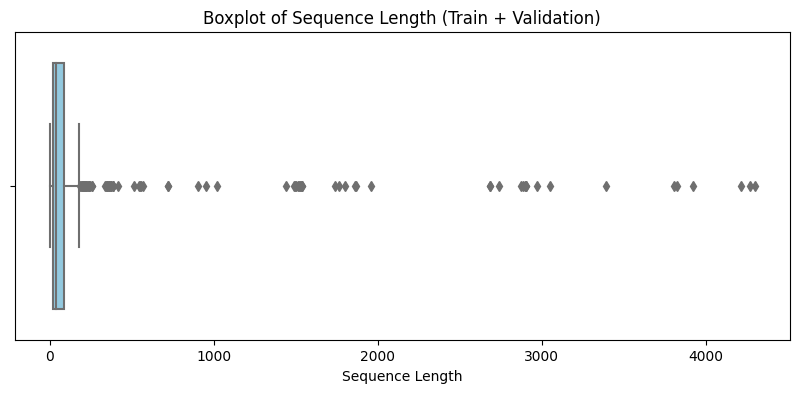

In [5]:
"""
Cell 3: COMBINE TRAIN + VALIDATION & BASIC EDA
----------------------------------------------
We concatenate the train and validation sets to maximize data. 
Then we do a quick EDA check on shapes, missingness, etc.
"""

# Combine sequences and labels
trainval_sequences = pd.concat(
    [train_sequences, validation_sequences], ignore_index=True
)
trainval_labels = pd.concat([train_labels, validation_labels], ignore_index=True)

logging.info(
    f"Combined train+validation sequences: {trainval_sequences.shape}, labels: {trainval_labels.shape}"
)

# Quick check for missing
logging.info(
    "Missing in combined sequences:\n" + str(trainval_sequences.isnull().sum())
)
logging.info("Missing in combined labels:\n" + str(trainval_labels.isnull().sum()))

# Example EDA: sequence length distribution
trainval_sequences["sequence_length"] = trainval_sequences["sequence"].str.len()

plt.figure(figsize=(10, 4))
sns.boxplot(x=trainval_sequences["sequence_length"], color="skyblue")
plt.title("Boxplot of Sequence Length (Train + Validation)")
plt.xlabel("Sequence Length")
plt.show()

logging.info("Cell 3 complete: Basic EDA finished.")

In [6]:
"""
Cell 4: HANDLE MISSING COORDINATES & MERGE
------------------------------------------
We replace '-1e18' with np.nan, then merge sequences with labels on target_id.
"""

# Replace -1e18 with np.nan in the labels
for col in ["x_1", "y_1", "z_1"]:
    trainval_labels[col] = trainval_labels[col].replace(-1e18, np.nan)

logging.info("Replaced -1e18 with NaN in trainval_labels for x_1, y_1, z_1.")

# Extract pdb_id, chain_id from ID
trainval_labels["pdb_id"] = trainval_labels["ID"].apply(lambda x: x.split("_")[0])
trainval_labels["chain_id"] = trainval_labels["ID"].apply(lambda x: x.split("_")[1])
trainval_labels["target_id"] = (
    trainval_labels["pdb_id"] + "_" + trainval_labels["chain_id"]
)

# Merge
train_data = pd.merge(trainval_labels, trainval_sequences, on="target_id", how="left")
logging.info(f"Merged train_data shape: {train_data.shape}")

# Quick check
logging.info(
    f"Missing in x_1: {train_data['x_1'].isnull().sum()}, "
    f"y_1: {train_data['y_1'].isnull().sum()}, "
    f"z_1: {train_data['z_1'].isnull().sum()}"
)

logging.info("Cell 4 complete: Merged train_data, ready for group-based imputation.")

In [7]:
"""
Cell 5: FEATURE ENGINEERING
---------------------------
Create numerical/categorical features from the 'sequence'.
We'll keep 'resname' from the labels as a valuable feature.
"""


def engineer_features(df):
    """
    Create numerical & (some) categorical features from raw RNA sequence data.
    """
    df = df.copy()
    # Sequence-based
    df["seq_length"] = df["sequence"].str.len()
    df["A_cnt"] = df["sequence"].str.count("A")
    df["C_cnt"] = df["sequence"].str.count("C")
    df["G_cnt"] = df["sequence"].str.count("G")
    df["U_cnt"] = df["sequence"].str.count("U")
    df["begin_seq"] = df["sequence"].str[0]
    df["end_seq"] = df["sequence"].str[-1]

    # Di-nucleotide counts (example set)
    for pair in [
        "AC",
        "AG",
        "AU",
        "CA",
        "CG",
        "CU",
        "GA",
        "GC",
        "GU",
        "UA",
        "UC",
        "UG",
        "AA",
        "CC",
        "GG",
        "UU",
    ]:
        df[f"{pair}_cnt"] = df["sequence"].str.count(pair)

    return df


# Apply feature engineering
train_data = engineer_features(train_data)

logging.info("Feature engineering applied to merged train_data.")

# We'll show an example of newly added columns
example_cols = [
    "seq_length",
    "A_cnt",
    "C_cnt",
    "G_cnt",
    "U_cnt",
    "begin_seq",
    "end_seq",
    "AC_cnt",
    "AA_cnt",
]
logging.info(f"Columns after FE sample:\n{train_data[example_cols].head(3)}")

logging.info("Cell 5 complete: Feature engineering done.")

In [8]:
"""
Cell 6: GROUP-BASED IMPUTATION
------------------------------
We impute missing x_1, y_1, z_1 within each (target_id, resname) group.
Finally, if any NAs remain, we fill them with a global median or drop them.
"""

# Perform group-based fill for x_1, y_1, z_1
train_data[["x_1", "y_1", "z_1"]] = (
    train_data.groupby(["target_id", "resname"])[["x_1", "y_1", "z_1"]]
    .apply(lambda grp: grp.fillna(grp.mean()))
    .reset_index(level=["target_id", "resname"], drop=True)
)

# In case any remain after group-based mean fill (e.g. group is all NaN), do a global fill
num_cols = ["x_1", "y_1", "z_1"]
global_imputer = SimpleImputer(strategy="median")
train_data[num_cols] = global_imputer.fit_transform(train_data[num_cols])

# If you'd prefer to drop any leftover NAs instead:
# train_data.dropna(subset=['x_1','y_1','z_1'], inplace=True)

logging.info("Group-based imputation + global median fallback complete.")

# Confirm missing values
logging.info(
    f"Remaining missing x_1: {train_data['x_1'].isna().sum()}, "
    f"y_1: {train_data['y_1'].isna().sum()}, z_1: {train_data['z_1'].isna().sum()}"
)

logging.info("Cell 6 complete: Group-based imputation finished.")

In [9]:
"""
Cell 7: PREPARE DATA FOR MODELING
---------------------------------
We'll define the columns we won't use, set up X and y for x_1, y_1, z_1, 
and one-hot encode any relevant categorical columns (including resname).
"""

# Unused columns
unused_cols = [
    "ID",
    "pdb_id",
    "chain_id",
    "resid",
    "x_1",
    "y_1",
    "z_1",
    "sequence",
    "description",
    "temporal_cutoff",
    "all_sequences",
    "target_id",  # key used for merges
]

# We'll keep resname, begin_seq, end_seq as features this time
feature_cols = [col for col in train_data.columns if col not in unused_cols]

# Make a copy
train_df = train_data.copy()

# Convert to categories
for cat_col in ["resname", "begin_seq", "end_seq"]:
    if cat_col in feature_cols:
        train_df[cat_col] = train_df[cat_col].astype("category")

# One-hot encode
train_df = pd.get_dummies(
    train_df, columns=["resname", "begin_seq", "end_seq"], drop_first=True
)

# Our final set of features
X_cols = [col for col in train_df.columns if col not in unused_cols]

X_full = train_df[X_cols]
y_x_full = train_df["x_1"]
y_y_full = train_df["y_1"]
y_z_full = train_df["z_1"]

logging.info(f"Feature matrix shape: {X_full.shape}")
logging.info("Cell 7 complete: Prepared data for modeling.")

In [ ]:
"""
Cell 8: KFold CV for X, Y, Z & Hyperparam Search
------------------------------------------------
We'll do a simplified KFold cross-validation for each coordinate 
to get a sense of good hyperparams, then train final models.
"""

import numpy as np
from sklearn.model_selection import RandomizedSearchCV

# Example hyperparameter grid (you can expand as needed)
param_dist = {
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [6, 10, 15],
    "n_estimators": [500, 800, 1000],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
}


def run_random_search(X, y, param_dist, n_iter=5, cv_splits=3):
    """Simple RandomizedSearchCV for an XGBRegressor using GPU in XGBoost >= 2.0."""
    xgb = XGBRegressor(tree_method="hist", device="cuda", random_state=42)
    rsearch = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring="neg_mean_squared_error",
        cv=cv_splits,
        verbose=1,
        random_state=42,
    )
    rsearch.fit(X, y)
    best_model = rsearch.best_estimator_
    logging.info(
        f"Best params: {rsearch.best_params_}, Best CV Score: {rsearch.best_score_}"
    )
    return best_model, rsearch.best_params_


logging.info("Starting hyperparam search for X coordinate.")
best_model_x, best_params_x = run_random_search(
    X_full, y_x_full, param_dist, n_iter=5, cv_splits=3
)

logging.info("Starting hyperparam search for Y coordinate.")
best_model_y, best_params_y = run_random_search(
    X_full, y_y_full, param_dist, n_iter=5, cv_splits=3
)

logging.info("Starting hyperparam search for Z coordinate.")
best_model_z, best_params_z = run_random_search(
    X_full, y_z_full, param_dist, n_iter=5, cv_splits=3
)

logging.info("Cell 8 complete: RandomizedSearchCV best params found.")

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:18:59] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [ ]:
"""
Cell 9: FINAL TRAINING ON FULL DATA
-----------------------------------
Use the best hyperparams for each coordinate found in CV. 
Retrain each coordinate model on all data (X_full, y_*_full).
"""


def get_best_xgb(params):
    """Return an XGBRegressor with the given params, using GPU."""
    # Here we override or add 'tree_method' to ensure GPU usage
    # We can also specify predictor='gpu_predictor' to accelerate inference on GPU
    model = XGBRegressor(
        **params,
        tree_method="hist",  # or tree_method=params.get('tree_method', 'hist')
        device="cuda",  # ensures GPU usage
        random_state=42,
    )
    return model


logging.info("Retraining final model for X coordinate...")
model_x = get_best_xgb(best_params_x)
model_x.fit(X_full, y_x_full)

logging.info("Retraining final model for Y coordinate...")
model_y = get_best_xgb(best_params_y)
model_y.fit(X_full, y_y_full)

logging.info("Retraining final model for Z coordinate...")
model_z = get_best_xgb(best_params_z)
model_z.fit(X_full, y_z_full)

logging.info("Cell 9 complete: Final models trained.")

In [ ]:
"""
Cell 10: PREPARE & ENGINEER TEST DATA
-------------------------------------
We expand test_sequences into (ID, resname, resid), merge with engineered features, 
and align columns with training's X_full. 
"""

# Expand test data row-by-row
test_expanded = []
for idx, row in test_sequences.iterrows():
    sequence_id = row["target_id"]
    seq_str = row["sequence"]
    for i, nucleotide in enumerate(seq_str, start=1):
        test_expanded.append([sequence_id, nucleotide, i])

test_clean_df = pd.DataFrame(test_expanded, columns=["ID", "resname", "resid"])
logging.info(f"test_clean_df shape: {test_clean_df.shape} (expanded test sequences)")

# We'll rename test_sequences -> test_feats for clarity, and engineer features
test_feats = engineer_features(test_sequences)

# FIX: use 'seq_length' instead of 'sequence_length' in drop() or remove the drop entirely
test_merged = pd.merge(
    test_clean_df,
    # drop 'seq_length' if you don't need it in final test features
    test_feats.drop(columns=["seq_length"]),
    left_on="ID",
    right_on="target_id",
    how="left",
)

logging.info(f"test_merged shape after merging: {test_merged.shape}")

# Convert any -1e18 to np.nan if present
for col in ["x_1", "y_1", "z_1"]:
    if col in test_merged.columns:
        test_merged[col] = test_merged[col].replace(-1e18, np.nan)

# Drop unneeded columns if present
drop_cols = ["sequence", "description", "temporal_cutoff", "all_sequences", "target_id"]
test_merged = test_merged.drop(
    columns=[c for c in drop_cols if c in test_merged.columns], errors="ignore"
)

logging.info("Now we align test_merged columns with training X.")

# Convert to category for 'resname','begin_seq','end_seq'
cat_cols = set(["resname", "begin_seq", "end_seq"]) & set(test_merged.columns)
for cat_col in cat_cols:
    test_merged[cat_col] = test_merged[cat_col].astype("category")

# One-hot encode
test_merged = pd.get_dummies(test_merged, columns=cat_cols, drop_first=True)

# Add missing columns from X_full
missing_cols = set(X_full.columns) - set(test_merged.columns)
for c in missing_cols:
    test_merged[c] = 0

# Drop any extra columns not in X_full
extra_cols = set(test_merged.columns) - set(X_full.columns)
if extra_cols:
    test_merged.drop(columns=extra_cols, inplace=True)

# Reorder columns
test_merged = test_merged[X_full.columns]

# Fill final missing numeric features with global_imputer
test_merged_imputed = pd.DataFrame(
    global_imputer.transform(test_merged), columns=test_merged.columns
)

logging.info("Cell 10 complete: Test data prepared & aligned.")

In [ ]:
"""
Cell 11: GENERATE PREDICTIONS & BUILD SUBMISSION
------------------------------------------------
We'll predict (x_1, y_1, z_1) for each residue, 
then replicate those coordinates for structures x_2..z_5.
Finally, we'll align with sample_submission and save submission.csv.
"""

# Predict x_1, y_1, z_1
test_pred_x = model_x.predict(test_merged_imputed)
test_pred_y = model_y.predict(test_merged_imputed)
test_pred_z = model_z.predict(test_merged_imputed)

# Build submission from test_clean_df
submission = test_clean_df.copy()

# Add predicted coords for structure 1
submission["x_1"] = test_pred_x
submission["y_1"] = test_pred_y
submission["z_1"] = test_pred_z

# For simplicity, replicate for structures 2..5
for i in [2, 3, 4, 5]:
    submission[f"x_{i}"] = test_pred_x
    submission[f"y_{i}"] = test_pred_y
    submission[f"z_{i}"] = test_pred_z

# Adjust ID format: ID + "_" + resid
submission["ID"] = submission["ID"] + "_" + submission["resid"].astype(str)

# Reorder columns to match sample_submission
final_cols = list(sample_submission.columns)  # ID, resname, resid, x_1..z_5
submission = submission[
    [
        "ID",
        "resname",
        "resid",
        "x_1",
        "y_1",
        "z_1",
        "x_2",
        "y_2",
        "z_2",
        "x_3",
        "y_3",
        "z_3",
        "x_4",
        "y_4",
        "z_4",
        "x_5",
        "y_5",
        "z_5",
    ]
]

# Merge with sample_submission to match row order
sample_submission["sort_order"] = range(len(sample_submission))
submission_merged = (
    pd.merge(submission, sample_submission[["ID", "sort_order"]], on="ID", how="left")
    .sort_values("sort_order")
    .drop(columns="sort_order")
)

# This is our final submission dataframe
submission_df = submission_merged.copy()

# Save to CSV
submission_df.to_csv("submission.csv", index=False)
logging.info("submission.csv created successfully.")

print("Cell 11 complete: Submission file saved. Ready to submit!")

In [ ]:
"""
Cell 12: CONCLUSIONS & NEXT STEPS
---------------------------------
We've done:
- Group-based imputation
- Preserved resname
- Hyperparameter tuning via RandomizedSearchCV
- Final training on full combined data
- Test predictions with the same coordinate repeated across 5 structures

Suggestions for further improvement:
- Fine-tune hyperparameters with a broader search or Bayesian optimization
- Explore more advanced RNA 3D features
- Generate truly distinct 5 structures instead of repeating the same coordinates
"""
logging.info("Notebook complete. Good luck on the leaderboard!")
print("All done! Submit 'submission.csv' to the competition.")